In [112]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
pd.set_option('display.max_columns', None)


df = pd.read_csv('../Data/pre-processed.csv',index_col=0)

In [113]:
#remove trips that are too long
df['z_score'] = np.abs((df['trip_time'] - df['trip_time'].mean()) / df['trip_time'].std())

# identify outliers
outliers = df[df['z_score'] > 3]['trip_time']

print(outliers)

df = df[df['z_score'] <= 3]
df.drop('z_score',axis=1,inplace=True)

293        0.230741
562        0.021915
982        0.044268
1166       0.007090
1585       0.033159
             ...   
2533184    0.055052
2533249    0.033259
2534387    0.009708
2534655    0.028755
2534698    0.009291
Name: trip_time, Length: 6526, dtype: float64


In [117]:
#feature selection using lasso
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
import numpy as np

X = df.drop('rideable_type_electric_bike',axis=1)
X = pd.get_dummies(X,columns=['start_station_cluster','end_station_cluster'])
# display(X.head())
# X = X.drop(['start_station_cluster','end_station_cluster'],axis=1)

# this is highly correlated with ridable type, but cannot really be used as a predictor
X.drop('average_speed',axis=1,inplace=True)

y = df['rideable_type_electric_bike']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

sel_ = Lasso(alpha=0.005, random_state=0)
sel_.fit(X_train, y_train)

criteria = sel_.coef_ != 0
selected_features = X.columns[criteria]
selected_features

Index(['end_lng', 'member_casual_member', 'start_station_cluster_2',
       'start_station_cluster_9', 'start_station_cluster_14',
       'start_station_cluster_17', 'start_station_cluster_18',
       'end_station_cluster_3', 'end_station_cluster_7',
       'end_station_cluster_9', 'end_station_cluster_14',
       'end_station_cluster_17', 'end_station_cluster_18'],
      dtype='object')

<Axes: >

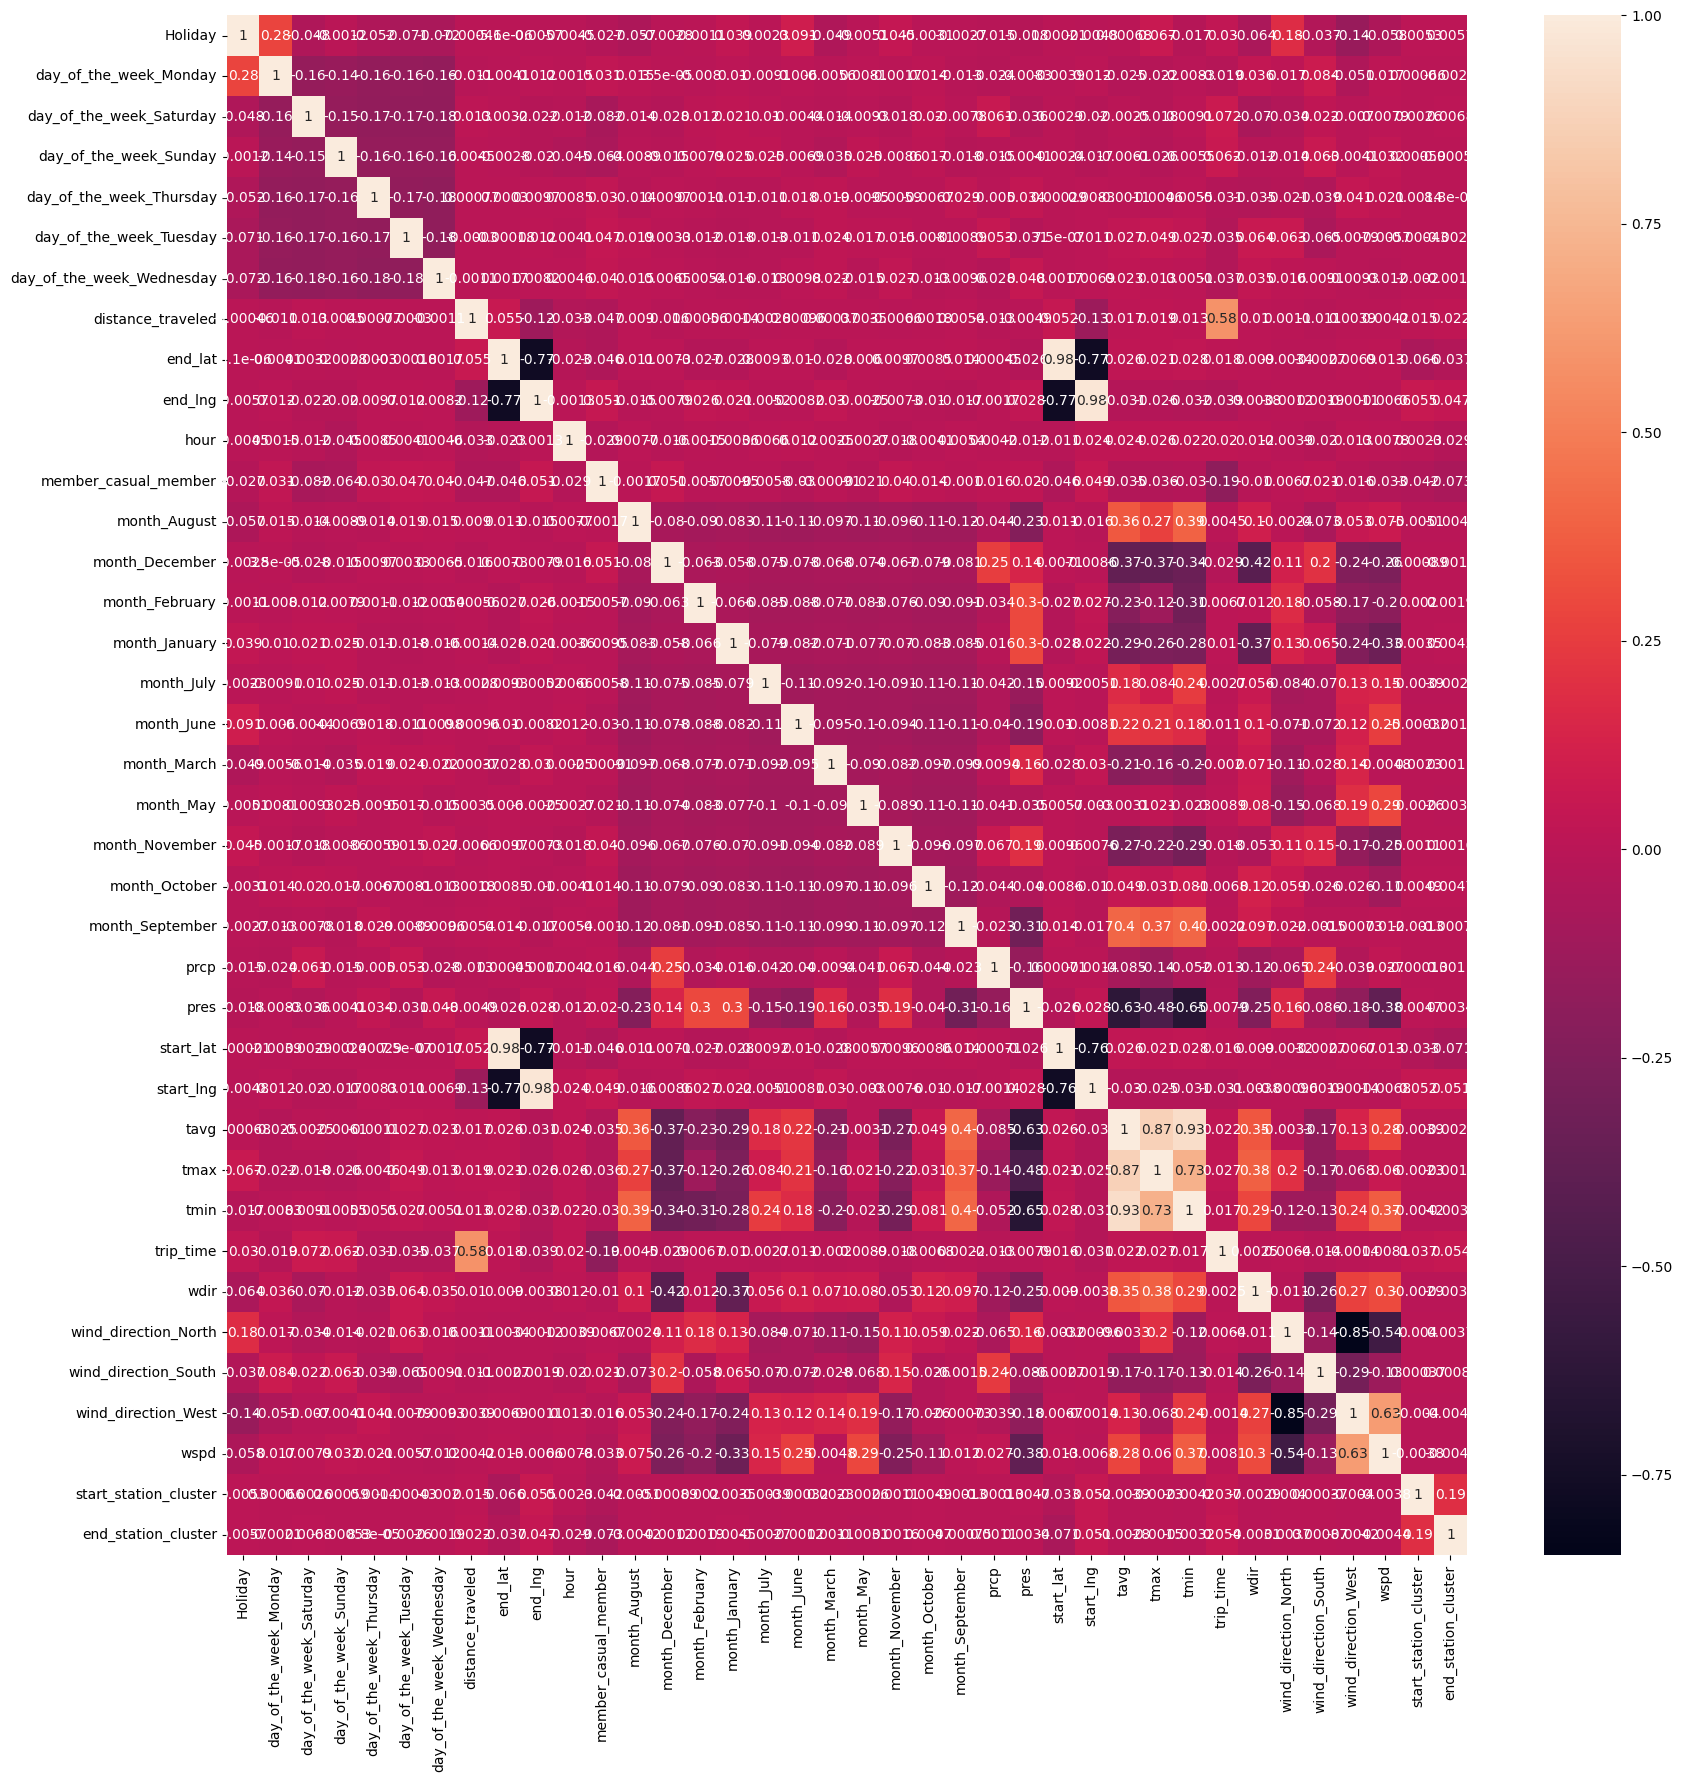

In [101]:
#check the correlation matrix of X
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
sns.heatmap(X.corr(),annot=True)

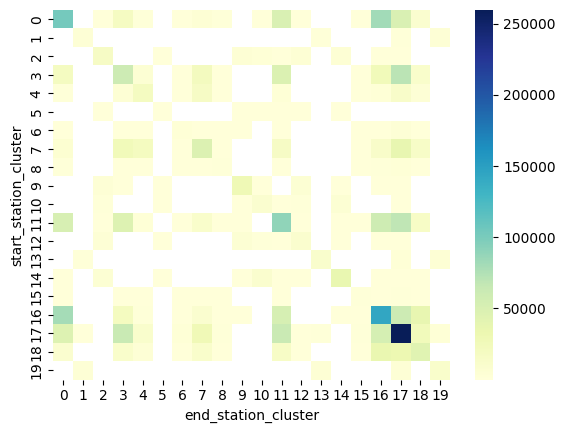

In [84]:
# heatmap of start and end station clusters
# group data by start and end station and count occurrences
counts = df.groupby(['start_station_cluster', 'end_station_cluster']).size().reset_index(name='count')

# create pivot table for heatmap
pivot_table = counts.pivot(index='start_station_cluster', columns='end_station_cluster', values='count')

# create heatmap
sns.heatmap(pivot_table, cmap='YlGnBu')

# show plot
plt.show()

In [122]:
#logistic regression on the data to predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

logit = LogisticRegression(max_iter=5000)
logit.fit(X_train,y_train)
logit_pred = logit.predict(X_test)
print(classification_report(y_test,logit_pred))

              precision    recall  f1-score   support

         0.0       0.71      0.41      0.52    268096
         1.0       0.74      0.91      0.81    490651

    accuracy                           0.73    758747
   macro avg       0.72      0.66      0.67    758747
weighted avg       0.73      0.73      0.71    758747



In [120]:
# try a random forest classifier
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train,y_train)
rfc_pred = rfc.predict(X_test)

print(classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.83      0.86    268096
         1.0       0.91      0.94      0.93    490651

    accuracy                           0.90    758747
   macro avg       0.90      0.89      0.89    758747
weighted avg       0.90      0.90      0.90    758747

